# Using ADAM-API to access MODIS Aqua

- you need to get an account to https://reliance.adamplatform.eu/ (use ORCID to authenticate) and key your ADAM API key
- make sure you save your ADAM API key in a file `$HOME/adam-key`

In [1]:
!pip install adamapi

In [2]:
import os
import glob
import pathlib
import zipfile
import adamapi as adam
import xarray as xr
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

In [3]:
adam_key = open(os.path.join(os.environ['HOME'],"adam-key")).read().rstrip()

In [4]:
a = adam.Auth()

a.setKey(adam_key)
a.setAdamCore('https://reliance.adamplatform.eu')
a.authorize()

{'expires_at': '2021-10-19T17:19:22.726Z',
 'access_token': 'c291b4e5f7e64f4597c2018a07cc8525',
 'refresh_token': '884a94c093d74d6196f8ac8b4115de72',
 'expires_in': 3600}

## Discover MOD_Aqua datasets 
- This step is useful to get the dataset identifier (unique for a given datacube)

In [5]:
def discoverDasasets(a, search_name):
    datasets = adam.Datasets(a)
    catalogue = datasets.getDatasets()
    #Extracting the size of the catalogue
    total = catalogue['properties']['totalResults']
    items = catalogue['properties']['itemsPerPage']
    pages = total//items
    
    print('----------------------------------------------------------------------')
    print('\033[1m' + 'List of available datasets:')
    print ('\033[0m')

    #Extracting the list of datasets across the whole catalogue
    for i in range(0,pages):
        page = datasets.getDatasets(page = i)
        for element in page['content']: 
            if search_name in element['title'] :
                print(element['title'] + "\033[1m" + " --> datasetId "+ "\033[0m" + "= " + element['datasetId'])
    return datasets

In [6]:
datasets = discoverDasasets(a, 'MOD_Aqua')

----------------------------------------------------------------------
List of available datasets:

MOD_Aqua_CHLa_MO_4km --> datasetId = 69618:MODh20chlMO_4km
MOD_Aqua_CHLa_YR_4km --> datasetId = 69616:MODh20chlYR_4km
MOD_Aqua_KD490_MO_4km --> datasetId = 69617:MODh20kd490MO_4km
MOD_Aqua_KD490_YR_4km --> datasetId = 69615:MODh20kd490YR_4km


## Get metadata from Modis Aqua Chlorophylle Concentration

In [7]:
datasetID = '69616:MODh20chlYR_4km'

print('\033[1;34m' + 'Metadata of ' + datasetID + ':')
print ('\033[0;0m')

paged = datasets.getDatasets(datasetID)
for i in paged.items():
    print("\033[1m" +  str(i[0]) + "\033[0m" + ': ' + str(i[1]))

Metadata of 69616:MODh20chlYR_4km:

datasetId: 69616:MODh20chlYR_4km
creationDate: 2018-01-01T00:00:01Z
dataType: Float32
epsg: 4326
keywords: ['/processing_control/input_parameters/NC_GLOBAL#alt_thresh_lat=999', '/processing_control/input_parameters/NC_GLOBAL#apply_pal=1', '/processing_control/input_parameters/NC_GLOBAL#central_meridian=-999', '/processing_control/input_parameters/NC_GLOBAL#deflate=4', '/processing_control/input_parameters/NC_GLOBAL#east=180.000', '/processing_control/input_parameters/NC_GLOBAL#fudge=1.0', '/processing_control/input_parameters/NC_GLOBAL#full_latlon=yes', '/processing_control/input_parameters/NC_GLOBAL#interp=area', '/processing_control/input_parameters/NC_GLOBAL#land=$OCDATAROOT/common/landmask_GMT15ARC.nc', '/processing_control/input_parameters/NC_GLOBAL#mask_land=no', '/processing_control/input_parameters/NC_GLOBAL#north=90.000', '/processing_control/input_parameters/NC_GLOBAL#num_cache=500', '/processing_control/input_parameters/NC_GLOBAL#oformat=2

## Discover and select products from a dataset
- for a given time range and spatial coverage

### Get data over Mediteranean region
- The geometry field is extracted from a GeoJSON object , retrieving the value of the "feature" element.

#### Search data
- only print the first 10 products

In [8]:
!pip install geojson_rewind

In [9]:
from adamapi import Search
from geojson_rewind import rewind
import json

The GeoJson object needs to be rearranged according to the counterclockwise winding order.This operation is executed in the next few lines to obtain a geometry that meets the requirements of the method. Geom_1 is the final result to be used in the discovery operation.

In [10]:
with open('mediteranean_region.geojson') as f:
    geom_dict = json.load(f)
output = rewind(geom_dict)    
geom_1 = str(geom_dict['features'][0]['geometry'])

In [11]:
geom_1

"{'type': 'Polygon', 'coordinates': [[[2.98828125, 44.84029065139799], [-6.0205078125, 38.61687046392973], [-5.053710937499999, 32.731840896865684], [13.403320312499998, 30.751277776257812], [23.994140624999996, 29.726222319395504], [21.708984375, 40.245991504199026], [15.99609375, 46.34692761055676], [3.1640625, 44.809121700077355], [2.98828125, 44.84029065139799]]]}"

In [12]:
start_date = '2010-01-01'
end_date = '2014-01-01'

In [13]:
search = Search( a )
results = search.getProducts(
    datasetID, 
    geometry= geom_1,
    startDate = start_date,
    endDate = end_date
 )

# Printing the results

print('\033[1m' + 'List of available products:')
print ('\033[0m')
count = 1
for i in results['content']:

        print("\033[1;31;1m" + "#" + str(count))
        print ('\033[0m')
        for k in i.items():
            print(str(k[0]) + ': ' + str(k[1]))
        count = count+1
        print('------------------------------------')

List of available products:

#1

_id: {'$oid': '60e8338e6dfebc0806bf8a50'}
datasetId: MODh20chlYR_4km
productDate: 2014-01-01T00:45:01Z
productId: NETCDF:"/mnt/VOL100T/reliance/MODISA_L3m_CHL/2014/01/01/A20140012014365.L3m_YR_CHL_chlor_a_4km.nc":chlor_a
band: 1
bandDescription: mass_concentration_chlorophyll_concentration_in_sea_water
geometry: {'geometries': [{'type': 'Polygon', 'coordinates': [[[-180, -90], [0.0, -90], [0.0, 89.9999975], [-180, 89.9999975], [-180, -90]]]}, {'type': 'Polygon', 'coordinates': [[[0.0, -90], [180, -90], [180, 89.9999975], [0.0, 89.9999975], [0.0, -90]]]}], 'type': 'GeometryCollection'}
insertDate: 2021-07-09T11:31:26Z
platform: A20
status: Online
------------------------------------
#2

_id: {'$oid': '60e8355e6dfebc0806c073d1'}
datasetId: MODh20chlYR_4km
productDate: 2013-01-01T00:10:01Z
productId: NETCDF:"/mnt/VOL100T/reliance/MODISA_L3m_CHL/2013/01/01/A20130012013365.L3m_YR_CHL_chlor_a_4km.nc":chlor_a
band: 1
bandDescription: mass_concentration_chlorop

## Get data
- be aware that you alwasy get daily average from ADAM-API 

In [14]:
def getZipData(auth, dataset_info):
    if not (pathlib.Path(pathlib.Path(dataset_info['outputFname']).stem).exists() or pathlib.Path(dataset_info['outputFname']).exists()):
        data = adam.GetData(auth)
        image = data.getData(
        datasetId = dataset_info['datasetID'],
        startDate = dataset_info['startDate'],
        endDate = dataset_info['endDate'],
        geometry = dataset_info['geometry'],
        outputFname = dataset_info['outputFname'])
        print(image)

In [15]:
%%time

output_file = './MOD_Aqua_mass_concentration_chlorophyll_concentration_in_sea_water_' + start_date + '-' + end_date + '.zip'

datasetInfo = {
    'datasetID'   : datasetID,
    'startDate'   : start_date,
    'endDate'     : end_date,
    'geometry'    : geom_1,
    'outputFname' : output_file
    }
getZipData(a, datasetInfo)

./MOD_Aqua_mass_concentration_chlorophyll_concentration_in_sea_water_2010-01-01-2014-01-01.zip
CPU times: user 2.54 s, sys: 186 ms, total: 2.72 s
Wall time: 3min 3s


## Data analysis and Visualization

### Unzip data 

In [16]:
def unzipData(filename):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(path = pathlib.Path(filename).stem)

In [17]:
if not pathlib.Path(pathlib.Path(output_file).stem).exists():
    unzipData(output_file)

## Read data in xarray

In [18]:
def paths_to_datetimeindex(paths):
    return  [datetime.strptime(date.split('_')[-1].split('.')[0], '%Y-%m-%dt%f') for date in paths]

In [19]:
def getData(dirtif, varname):
    geotiff_list = glob.glob(dirtif)
    # Create variable used for time axis
    time_var = xr.Variable('time', paths_to_datetimeindex(geotiff_list))
    # Load in and concatenate all individual GeoTIFFs
    geotiffs_da = xr.concat([xr.open_rasterio(i, parse_coordinates=True) for i in geotiff_list],
                        dim=time_var)
    # Covert our xarray.DataArray into a xarray.Dataset
    geotiffs_da = geotiffs_da.to_dataset('band')
    # Rename the dimensions to make it CF-convention compliant
    geotiffs_da = geotiffs_da.rename_dims({'y': 'latitude', 'x':'longitude'})
    # Rename the variable to a more useful name
    geotiffs_da = geotiffs_da.rename_vars({1: varname, 'y':'latitude', 'x':'longitude'})
    # set attribute to variable
    geotiffs_da[varname].attrs = {'units' : geotiffs_da.attrs[varname + '#units'], 'long_name' : geotiffs_da.attrs[varname + '#long_name']}
    return geotiffs_da

In [20]:
path_files = os.path.join(pathlib.Path(output_file).stem, '*.tif')
geotiff_ds = getData(path_files, 'chlor_a')

## Visualization

### Visualize all years

/opt/conda/lib/python3.8/site-packages/xarray/plot/facetgrid.py:390: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


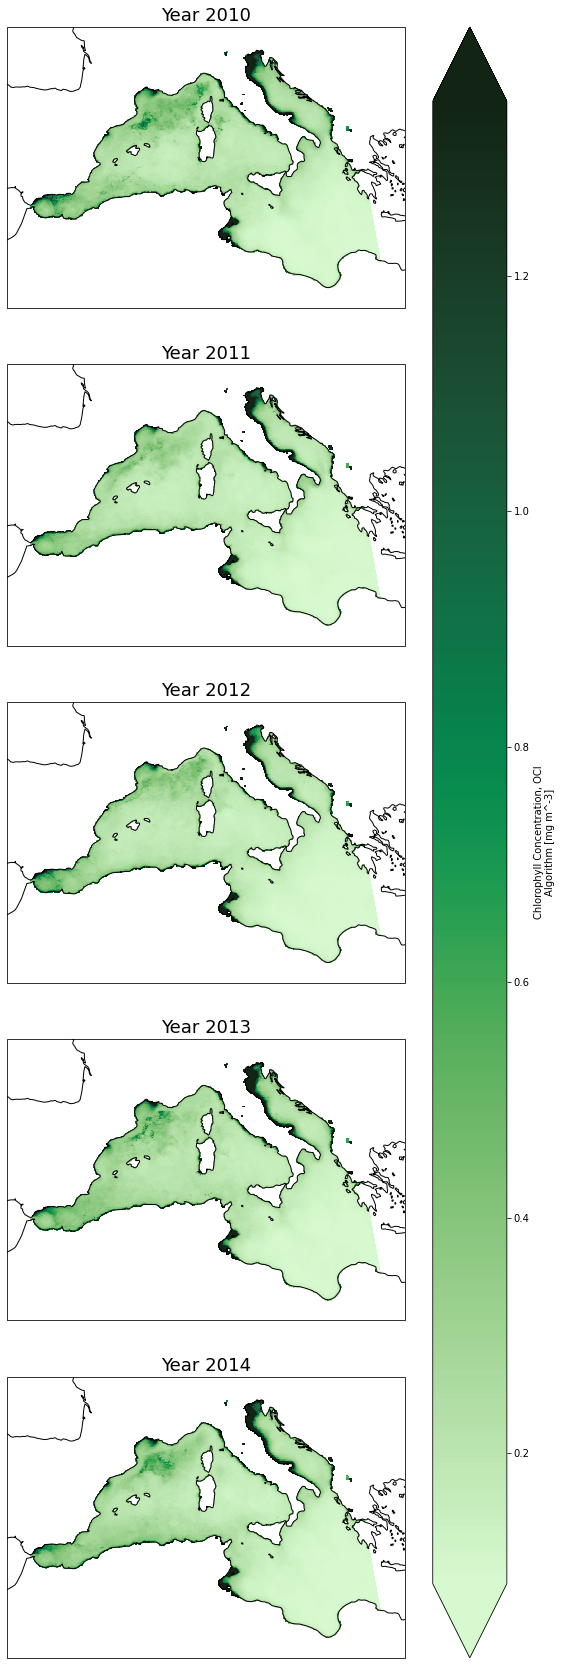

In [21]:
proj_plot = ccrs.Mercator()

minval = 0
p = geotiff_ds['chlor_a'].where(geotiff_ds['chlor_a']>0).plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(),
                             aspect=geotiff_ds.dims["longitude"] / geotiff_ds.dims["latitude"],  # for a sensible figsize
                             subplot_kws={"projection": proj_plot},
                             col='time', col_wrap=1, robust=True, cmap=cmocean.cm.algae)
# We have to set the map's options on all four axes
for ax,i in zip(p.axes.flat,  geotiff_ds.time.dt.year.values):
    ax.coastlines()
    ax.set_title('Year '+ str(i), fontsize=18)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10., 30.)
fig.savefig('Mod_Aqua-chlor_a.png', dpi=100)

### Visualize one year for sketch

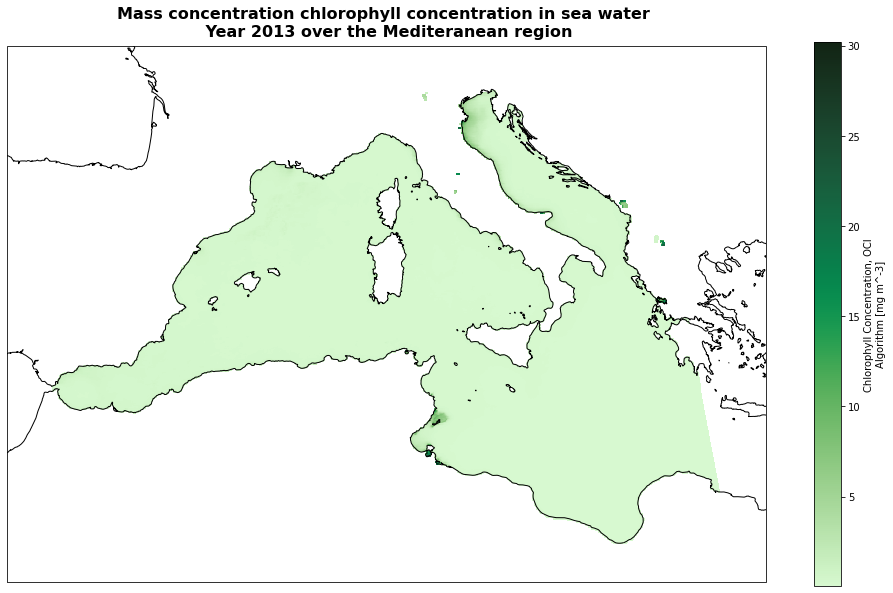

In [22]:
fig=plt.figure(figsize=(17,10))
# Define the projection
crs=ccrs.PlateCarree()

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=12.0))
ax.coastlines(resolution='10m')

# We need to project our data to the new Mercator projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
# we only plot values greather than 0
img = geotiff_ds['chlor_a'].where(geotiff_ds['chlor_a']>0).sel(time='2013-01-01').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.algae)  

# Title for plot
plt.title('Mass concentration chlorophyll concentration in sea water \n Year 2013 over the Mediteranean region',fontsize = 16, fontweight = 'bold', pad=10)
plt.savefig('Mod_Aqua-chlor_MED_2013.png')

## Create a Research Object

In [23]:
import os
from modules.rohub import rohub, settings

#### Authenticating

- If the code cell below fails,  make sure you have created the two files:
    - `rohub-user`: contains your rohub username
    - `rohub-pwd`: contains your rohub password

In [24]:
rohub_user = open("rohub-user").read().rstrip()
rohub_pwd = open("rohub-pwd").read().rstrip()
rohub.login(username=rohub_user, password=rohub_pwd)

Logged successfully as annefou.


## Create new basic RO

In [25]:
ro_title="Mod Aqua mass concentration chlorophyll concentration in sea water 2010-2014 Code Research Object"
ro_research_areas=["Earth sciences"]

ro = rohub.ros_create(title=ro_title, research_areas=ro_research_areas)

Research Object was successfully created with id = 5d276dc4-b8e6-4128-b8a6-d6bca981f8aa


## Show basic metadata

In [26]:
ro.show_metadata()

{'identifier': '5d276dc4-b8e6-4128-b8a6-d6bca981f8aa',
 'shared_link': 'https://w3id.org/ro-id/5d276dc4-b8e6-4128-b8a6-d6bca981f8aa',
 'title': 'Mod Aqua mass concentration chlorophyll concentration in sea water 2010-2014 Code Research Object',
 'description': None,
 'status': 'LIVE',
 'access_mode': 'PUBLIC',
 'type': 'Basic Research Object',
 'template': None,
 'created': '2021-10-19T16:22:47.510896Z',
 'creator': 'annefou',
 'modificator': 'annefou',
 'modified': None,
 'importer': None,
 'research_areas': ['Earth sciences'],
 'owner': 'annefou',
 'editors': [],
 'readers': [],
 'rating': '0.00',
 'number_of_ratings': 0,
 'number_of_likes': 0,
 'number_of_dislikes': 0,
 'quality': 0,
 'size': 0,
 'creation_mode': 'MANUAL',
 'doi': None,
 'api_link': 'https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/ros/5d276dc4-b8e6-4128-b8a6-d6bca981f8aa/'}

### Add metadata associated to our Research Object

In [27]:
ro.description="This Research Object demonstrate how to use ADAM API to retrieve MOD_Aqua mass concentration chlorophyll concentration in sea water over a given area and time range"
ro.ros_type="Code Research Research Object"

ro.update()

{'identifier': '5d276dc4-b8e6-4128-b8a6-d6bca981f8aa',
 'shared_link': 'https://w3id.org/ro-id/5d276dc4-b8e6-4128-b8a6-d6bca981f8aa',
 'title': 'Mod Aqua mass concentration chlorophyll concentration in sea water 2010-2014 Code Research Object',
 'description': 'This Research Object demonstrate how to use ADAM API to retrieve MOD_Aqua mass concentration chlorophyll concentration in sea water over a given area and time range',
 'status': 'LIVE',
 'access_mode': 'PUBLIC',
 'type': 'Code Research Research Object',
 'template': None,
 'created': '2021-10-19T16:22:47.510896Z',
 'creator': 'annefou',
 'modificator': 'annefou',
 'modified': '2021-10-19T16:22:49.753936Z',
 'importer': None,
 'research_areas': ['Earth sciences'],
 'owner': 'annefou',
 'editors': [],
 'readers': [],
 'rating': '0.00',
 'number_of_ratings': 0,
 'number_of_likes': 0,
 'number_of_dislikes': 0,
 'quality': 0,
 'size': 1758,
 'creation_mode': 'MANUAL',
 'doi': None,
 'api_link': 'https://rohub2020-rohub.apps.paas-dev.

## Aggregate resource (internal)

#### Add our Jupyter Notebook to our Research Object

In [28]:
resi_file_path='MOD_Aqua_ADAM.ipynb'

if pathlib.Path(resi_file_path).exists():
    resi_res_type="Python Script"
    resi_title="Retrieve and visualize yearly mean maps of MOD_Aqua Chlo_a for different years"
    resi_description="Jupyter Notebook for discovering, accessing and processing and visualizing RELIANCE data cube of MOD_Aqua Chlo_a over different years"
    ro.add_internal_resource(res_type=resi_res_type,file_path=resi_file_path, title=resi_title, description=resi_description)

### Add figure as sketch

In [29]:
resi_res_type="Sketch"
resi_file_path="Mod_Aqua-chlor_MED_2013.png"
resi_title="Map of MOD_Aqua mass concentration chlorophyll concentration in sea water over the mediteranean region in 2013"

ro.add_internal_resource(res_type=resi_res_type,file_path=resi_file_path, title=resi_title)

{'identifier': '47d31f8d-8f6c-496a-b3ec-1c8561c744e6',
 'title': 'Map of MOD_Aqua mass concentration chlorophyll concentration in sea water over the mediteranean region in 2013',
 'folder': None,
 'ros': ['5d276dc4-b8e6-4128-b8a6-d6bca981f8aa'],
 'description': None,
 'url': None,
 'name': 'Map of MOD_Aqua mass concentration chlorophyll concentration in sea water over the mediteranean region in 2013',
 'filename': 'Mod_Aqua-chlor_MED_2013.png',
 'path': 'Mod_Aqua-chlor_MED_2013.png',
 'size': 110489,
 'download_url': 'https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/resources/47d31f8d-8f6c-496a-b3ec-1c8561c744e6/download/',
 'type': 'Sketch',
 'doi': None,
 'read_only': False,
 'cloned': None,
 'api_link': 'https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/resources/47d31f8d-8f6c-496a-b3ec-1c8561c744e6/'}

In [30]:
### Add other figure as results

In [31]:
resi_res_type="Result"
resi_file_path="Mod_Aqua-chlor_a.png"
resi_title="Yearly maps (2010-2014) of MOD_Aqua mass concentration chlorophyll concentration in sea water over the mediteranean region"

ro.add_internal_resource(res_type=resi_res_type,file_path=resi_file_path, title=resi_title)

{'identifier': 'd67c341a-30a5-4640-80ad-27ad507c43ef',
 'title': 'Yearly maps (2010-2014) of MOD_Aqua mass concentration chlorophyll concentration in sea water over the mediteranean region',
 'folder': None,
 'ros': ['5d276dc4-b8e6-4128-b8a6-d6bca981f8aa'],
 'description': None,
 'url': None,
 'name': 'Yearly maps (2010-2014) of MOD_Aqua mass concentration chlorophyll concentration in sea water over the mediteranean region',
 'filename': 'Mod_Aqua-chlor_a.png',
 'path': 'Mod_Aqua-chlor_a.png',
 'size': 599688,
 'download_url': 'https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/resources/d67c341a-30a5-4640-80ad-27ad507c43ef/download/',
 'type': 'Result',
 'doi': None,
 'read_only': False,
 'cloned': None,
 'api_link': 'https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/resources/d67c341a-30a5-4640-80ad-27ad507c43ef/'}

#### Add Data cube selection as internal resource 
- because it is small; otherwise I would need to save this file in a different location (maybe separately in zenodo or Pangea)

In [32]:
geotiff_ds['chlor_a'].to_netcdf('MOD_Aqua_Chlo_a_2010-2014.nc')

In [33]:
resi_file_path = 'MOD_Aqua_Chlo_a_2010-2014.nc'
resi_res_type = "Result"
resi_title = "Yearly mean data of MOD_Aqua Chlo_a from 2010 to 2014"
resi_description = "netCDF data corresponding to data cube of MOD_Aqua Chlo_a from 2010 to 2014"
ro.add_internal_resource(res_type=resi_res_type,file_path=resi_file_path, title=resi_title, description=resi_description)

{'identifier': 'd1e9e924-24a4-4c25-a56d-6ed8d9eacba9',
 'title': 'Yearly mean data of MOD_Aqua Chlo_a from 2010 to 2014',
 'folder': None,
 'ros': ['5d276dc4-b8e6-4128-b8a6-d6bca981f8aa'],
 'description': 'netCDF data corresponding to data cube of MOD_Aqua Chlo_a from 2010 to 2014',
 'url': None,
 'name': 'Yearly mean data of MOD_Aqua Chlo_a from 2010 to 2014',
 'filename': 'MOD_Aqua_Chlo_a_2010-2014.nc',
 'path': 'MOD_Aqua_Chlo_a_2010-2014.nc',
 'size': 5786909,
 'download_url': 'https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/resources/d1e9e924-24a4-4c25-a56d-6ed8d9eacba9/download/',
 'type': 'Result',
 'doi': None,
 'read_only': False,
 'cloned': None,
 'api_link': 'https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/resources/d1e9e924-24a4-4c25-a56d-6ed8d9eacba9/'}

#### Add geographical geojson file as internal resources


In [34]:
resi_file_path = 'mediteranean_region-ld.geojson'
resi_res_type = "Result"
resi_title = "Geographical area (geojson) file use to select data from EDAM Platform"
resi_description = "JSON-LD format covering the mediteranean region for this analysis"
ro.add_internal_resource(res_type=resi_res_type,file_path=resi_file_path, title=resi_title, description=resi_description)

{'identifier': 'c131ee85-1f18-40aa-a2f1-3cb15e9e78bf',
 'title': 'Geographical area (geojson) file use to select data from EDAM Platform',
 'folder': None,
 'ros': ['5d276dc4-b8e6-4128-b8a6-d6bca981f8aa'],
 'description': 'JSON-LD format covering the mediteranean region for this analysis',
 'url': None,
 'name': 'Geographical area (geojson) file use to select data from EDAM Platform',
 'filename': 'mediteranean_region-ld.geojson',
 'path': 'mediteranean_region-ld.geojson',
 'size': 734,
 'download_url': 'https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/resources/c131ee85-1f18-40aa-a2f1-3cb15e9e78bf/download/',
 'type': 'Result',
 'doi': None,
 'read_only': False,
 'cloned': None,
 'api_link': 'https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/resources/c131ee85-1f18-40aa-a2f1-3cb15e9e78bf/'}

#### Add Data cube information as external resources

In [35]:
rese_res_type="Data Cube Collection"
rese_file_url="https://reliance-das.adamplatform.eu/opensearch/datasets?datasetId=MOD_Aqua_CHLa_YR_4km"
rese_title="MOD_Aqua_CHLa_YR_4km"
rese_description="This dataset provides yearly mass concentration chlorophyll concentration in sea water (MOD_Aqua)"
ro.add_external_resource(res_type=rese_res_type, url=rese_file_url, title=rese_title, description= rese_description)

{'identifier': 'a2c943ae-389f-4b5b-8d9f-f73a48d34fe1',
 'title': 'MOD_Aqua_CHLa_YR_4km',
 'folder': None,
 'ros': ['5d276dc4-b8e6-4128-b8a6-d6bca981f8aa'],
 'description': 'This dataset provides yearly mass concentration chlorophyll concentration in sea water (MOD_Aqua)',
 'url': 'https://reliance-das.adamplatform.eu/opensearch/datasets?datasetId=MOD_Aqua_CHLa_YR_4km',
 'name': 'MOD_Aqua_CHLa_YR_4km',
 'filename': None,
 'path': 'https://reliance-das.adamplatform.eu/opensearch/datasets?datasetId=MOD_Aqua_CHLa_YR_4km',
 'size': None,
 'download_url': 'https://reliance-das.adamplatform.eu/opensearch/datasets?datasetId=MOD_Aqua_CHLa_YR_4km',
 'type': 'Data Cube Collection',
 'doi': None,
 'read_only': False,
 'cloned': None,
 'api_link': 'https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/resources/a2c943ae-389f-4b5b-8d9f-f73a48d34fe1/'}

In [36]:
rese_res_type2="Data Cube Product"
rese_file_url2="https://reliance-das.adamplatform.eu/opensearch/search?datasetId=MOD_Aqua_CHLa_YR_4km&startDate=2010-01-01&endDate=2014-01-01"
rese_title2="MOD_Aqua_CHLa_YR_4km from 2010 to 2014"
rese_description2="List of yearly mass concentration chlorophyll concentration in sea water"

ro.add_external_resource(res_type=rese_res_type2, url=rese_file_url2, title=rese_title2, description=rese_description2)

{'identifier': '6ec1991a-88de-46ed-9469-ae5da0e91fb6',
 'title': 'MOD_Aqua_CHLa_YR_4km from 2010 to 2014',
 'folder': None,
 'ros': ['5d276dc4-b8e6-4128-b8a6-d6bca981f8aa'],
 'description': 'List of yearly mass concentration chlorophyll concentration in sea water',
 'url': 'https://reliance-das.adamplatform.eu/opensearch/search?datasetId=MOD_Aqua_CHLa_YR_4km&startDate=2010-01-01&endDate=2014-01-01',
 'name': 'MOD_Aqua_CHLa_YR_4km from 2010 to 2014',
 'filename': None,
 'path': 'https://reliance-das.adamplatform.eu/opensearch/search?datasetId=MOD_Aqua_CHLa_YR_4km&startDate=2010-01-01&endDate=2014-01-01',
 'size': None,
 'download_url': 'https://reliance-das.adamplatform.eu/opensearch/search?datasetId=MOD_Aqua_CHLa_YR_4km&startDate=2010-01-01&endDate=2014-01-01',
 'type': 'Data Cube Product',
 'doi': None,
 'read_only': False,
 'cloned': None,
 'api_link': 'https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/resources/6ec1991a-88de-46ed-9469-ae5da0e91fb6/'}

In [37]:
ro.add_geolocation(body_specification_json="mediteranean_region.geojson")

[{'identifier': '6f175279-b82e-431d-b3ad-d3015b81af2d',
  'name': 'annotations/6f175279-b82e-431d-b3ad-d3015b81af2d',
  'filename': '.ro/annotations/6f175279-b82e-431d-b3ad-d3015b81af2d.ttl',
  'relation': False,
  'read_only': False,
  'target': '5d276dc4-b8e6-4128-b8a6-d6bca981f8aa',
  'ro': '5d276dc4-b8e6-4128-b8a6-d6bca981f8aa',
  'resources': [],
  'created': '2021-10-19T16:23:01.709222Z',
  'creator': 'annefou',
  'modificator': None,
  'modified': None,
  'api_link': 'https://rohub2020-rohub.apps.paas-dev.psnc.pl/api/annotations/6f175279-b82e-431d-b3ad-d3015b81af2d/'}]

### Publish my Research Object to Zenodo
- Take a snapshot and publis my RO to zenodo

In [38]:
# uncomment to publish in zenodo
# snapshot_id=ro.snapshot(publication_services=["Zenodo"])

### Load the published Research Object (to check)

In [39]:
# published_ro = rohub.ros_load(identifier=snapshot_id)

### Show the DOI and get the link

In [40]:
#published_ro.show_publication()